In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
#################################
# check the symmetry of H1
#################################
H1_path = '../data/balanced_product/h1_inputBalancedProduct.txt'
H2_path = '../data/balanced_product/h2_inputBalancedProduct.txt'
Hx_path = '../data/balanced_product/hx_outputBalancedProduct.txt'
Hz_path = '../data/balanced_product/hz_outputBalancedProduct.txt'
H1 = np.loadtxt(H1_path, dtype=int)
for i in range(len(H1)):
    for j in range(len(H1[i])):
        # print(H1[i][j] == H1[(i+17)%255][(j+29)%435])
        assert H1[i][j] == H1[(i+17)%255][(j+29)%435]
# print(H1.shape)
# H1_coarse_grained = np.zeros((15, 15, H1.shape[0]//15, H1.shape[1]//15))
# for bi in range(15):
#     for bj in range(15):
#         H1_coarse_grained[bi, bj] = H1[bi*15:(bi+1)*15,bj*29:(bj+1)*29]
# # print(H1_coarse_grained)
# for bi in range(15):
#     for bj in range(15):
#         assert np.all(H1_coarse_grained[bi, bj] == H1_coarse_grained[0, 0])
# H1_coarse_grained = H1.reshape((15, H1.shape[0]//15, 15, H1.shape[1]//15))
# for bi in range(15):
#     for bj in range(15):
#         assert np.all(H1_coarse_grained[bi, :, bj, :] == H1_coarse_grained[(bi-1)%15, :, (bj-1)%15, :])

#################################
# check the shape of Hz and Hx
#################################
Hx = np.loadtxt(Hx_path, dtype=int)
Hz = np.loadtxt(Hz_path, dtype=int)
# print(Hx.shape)
# print(Hz.shape)

#################################
# Reproduce Hx
# (construct the basis of 
# double complex using anti-
# diagonal symmetry operations)
#################################
H1 = np.loadtxt(H1_path, dtype=int)
H2 = np.loadtxt(H2_path, dtype=int)
Hx_my = np.zeros((255, 690), dtype=int)
Hz_my = np.zeros((435, 690), dtype=int)

def find_orbit_inner(i1, j1, i2, j2, blockshape1):
    '''
    (i1, j1): coordinate of matrix H1, H1.T, I_m1 or I_n1, depending on the situation
    (i2, j2): coordinate of matrix H2, H2.T, I_m2 or I_n2, but all of them are 15x15 matrices
    '''
    bi1 = i1//blockshape1[0]
    bj1 = j1//blockshape1[1]
    ci1 = i1%blockshape1[0]
    cj1 = j1%blockshape1[1]
    orbital_i = (bi1 + i2)%15
    orbital_j = (bj1 + j2)%15
    return ci1, cj1, orbital_i, orbital_j

def build_Hx_left():
    def find_qubits_involved_left(orbital_i, ci1):
        '''orbital_i: row index of the blocks of H1
           ci1: row index within each block of H1
           NOTE: the blocks of H1 are right-tilted-diagonal invariant
        '''
        orbits_inner_to_find = np.where(H1[0*17+ci1])[0]
        'The above line finds what columns indices in the ci1-th row within the first block of H1 are non-zero.'
        lst = []
        for col in orbits_inner_to_find:
            qubit = find_orbit_inner(0*17+ci1, col, orbital_i, orbital_i, blockshape1=(17, 29))
            if not (qubit in lst):
                lst.append(qubit)
        return lst
    Hx_left = np.zeros((15, 17, 15, 29), dtype=int)
    for orbital_i in range(15):
        for ci1 in range(17):
            to_process = find_qubits_involved_left(orbital_i, ci1)
            for qubit in to_process:
                Hx_left[orbital_i, ci1, qubit[3], qubit[1]] = 1
    return Hx_left.reshape((255, 435))

def build_Hx_right():
    '''Hx_right is reduced from I_m1 \otimes H2.T by modding Z15 symmetry.
    '''
    def find_qubits_involved_right(orbital_i, ci1):
        '''orbital_i: row index of the blocks of H1
           ci1: row index within each block of H1
           NOTE: the blocks of H1 are right-tilted-diagonal invariant
        '''
        orbits_inner_to_find = np.where(H2.T[0])[0]
        'The above line finds what columns indices in the 0-th row of H2.T are non-zero.'
        lst = []
        for col in orbits_inner_to_find:
            qubit = find_orbit_inner(orbital_i*17+ci1, orbital_i*17+ci1, 0, col, blockshape1=(17, 17))
            if not (qubit in lst):
                lst.append(qubit)
        return lst
    Hx_right = np.zeros((15, 17, 15, 17), dtype=int)
    for orbital_i in range(15):
        for ci1 in range(17):
            to_process = find_qubits_involved_right(orbital_i, ci1)
            for qubit in to_process:
                Hx_right[orbital_i, ci1, qubit[3], qubit[1]] = 1
    return Hx_right.reshape((255, 255))

Hx_left = build_Hx_left()
Hx_right = build_Hx_right()
print('Hx_left correct? ', np.all(Hx_left == Hx[:,0:435]))
print('Hx_right correct? ', np.all(Hx_right == Hx[:,435:690]))
    
#################################
# Reproduce Hz
#################################

def build_Hz_left():
    '''reducing from I_n1 \otimes H2'''
    def find_qubits_involved(orbital_i, ci1):
        '''orbital_i: row index of the blocks of H1
           ci1: row index within each block of H1
           NOTE: the blocks of H1 are right-tilted-diagonal invariant
        '''
        orbits_inner_to_find = np.where(H2[0])[0]
        'The above line finds what columns indices in the 0-th row of H2 are non-zero.'
        lst = []
        for col in orbits_inner_to_find:
            qubit = find_orbit_inner(orbital_i*29+ci1, orbital_i*29+ci1, 0, col, blockshape1=(29, 29))
            if not (qubit in lst):
                lst.append(qubit)
        return lst
    Hz_left = np.zeros((15, 29, 15, 29), dtype=int)
    for orbital_i in range(15):
        for ci1 in range(29):
            to_process = find_qubits_involved(orbital_i, ci1)
            for qubit in to_process:
                Hz_left[orbital_i, ci1, qubit[3], qubit[1]] = 1
    return Hz_left.reshape((435, 435))

def build_Hz_right():
    '''Reducing from H1.T \otimes I_m2'''
    def find_qubits_involved(orbital_i, ci1):
        '''orbital_i: row index of the blocks of H1
           ci1: row index within each block of H1
           NOTE: the blocks of H1 are right-tilted-diagonal invariant
        '''
        orbits_inner_to_find = np.where(H1.T[0*29+ci1])[0]
        'The above line finds what columns indices in the ci1-th row within the first block of H1.T are non-zero.'
        lst = []
        for col in orbits_inner_to_find:
            qubit = find_orbit_inner(0*29+ci1, col, orbital_i, orbital_i, blockshape1=(29, 17))
            if not (qubit in lst):
                lst.append(qubit)
        return lst
    Hz_right = np.zeros((15, 29, 15, 17), dtype=int)
    for orbital_i in range(15):
        for ci1 in range(29):
            to_process = find_qubits_involved(orbital_i, ci1)
            for qubit in to_process:
                Hz_right[orbital_i, ci1, qubit[3], qubit[1]] = 1
    return Hz_right.reshape((435, 255))

Hz_left = build_Hz_left()
Hz_right = build_Hz_right()
print('Hz_left correct? ', np.all(Hz_left == Hz[:,0:435]))
print('Hz_right correct? ', np.all(Hz_right == Hz[:,435:690]))

Hx_left correct?  True
Hx_right correct?  True
Hz_left correct?  True
Hz_right correct?  True


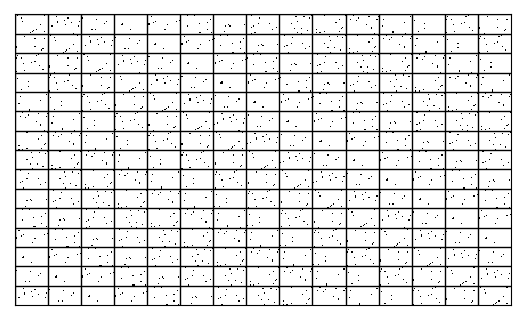

In [14]:
# visualize h1
# element 0 to white, element 1 to black
fig, ax = plt.subplots()
cax = ax.matshow(H1, cmap='binary')
for i in range(15):
    # horizontal lines
    ax.axhline(i*17-0.5, color='black', linewidth=1)
    # vertical lines
    ax.axvline(i*29-0.5, color='black', linewidth=1)
ax.set_xticks([])
ax.set_yticks([])
fig.savefig('h1_grid.png', dpi=600)

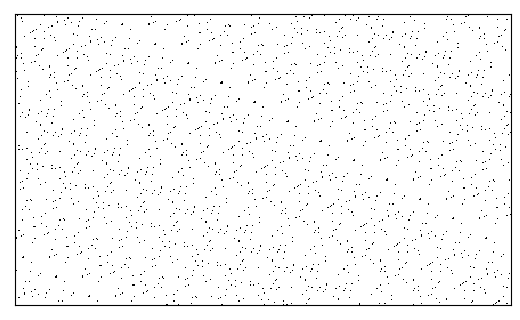

In [13]:
fig, ax = plt.subplots()
cax = ax.matshow(H1, cmap='binary')
ax.set_xticks([])
ax.set_yticks([])
fig.savefig('h1.png', dpi=600)